### Alex Stute - Final Project Work

Initial Imports

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


Loading Data

In [42]:
os.chdir('c:\\Users\\stute\\OneDrive - University of Vermont\\Fall 2024\\Machine Learning\\Final Project Things\\CS5990-Group7-Final-Project')

PATH_TO_TRAINING_DATA = '\\archive\\sign_mnist_train'
PATH_TO_TEST_DATA = '\\archive\\sign_mnist_test'

# Get the training data
os.chdir(os.getcwd() + PATH_TO_TRAINING_DATA)
train_data = pd.read_csv(os.getcwd() + '\\sign_mnist_train.csv')

# Moves up two directories
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

# Get the testing data
os.chdir(os.getcwd() + PATH_TO_TEST_DATA)
test_data = pd.read_csv(os.getcwd() + '\\sign_mnist_test.csv')

# Moves up two directories
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

train_data_labels = train_data['label']
test_data_labels = test_data['label']

Check data loaded properly

In [43]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


**In the data, label 0 is 'A', label 1 is 'B', etc.**

No J or Z in the dataset

In [44]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

Test printing an image

In [45]:
row_label = train_data.iloc[0][0]
row_pixels = train_data.iloc[0][1:785]

C:\Users\stute\AppData\Local\Temp\ipykernel_22316\3766267553.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_label = train_data.iloc[0][0]


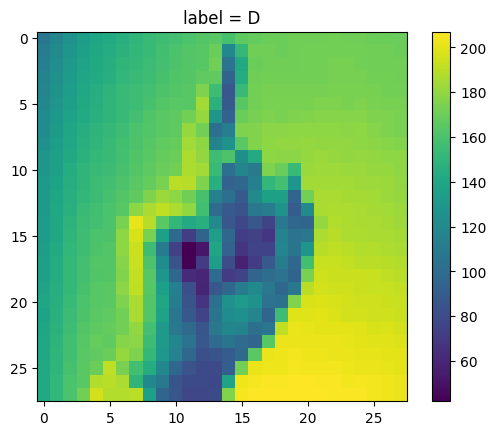

In [46]:
# Images are 28x28, so to view a row, reshape it into a 28x28 array
row_image = np.reshape(row_pixels, (28,28))
plt.imshow(row_image)
plt.title('label = ' + labels[row_label])
plt.colorbar()
plt.savefig('Image_'+'row_id'+'.png')
plt.show()

Keras stuff - CSV

In [47]:
import tensorflow as tf
from tensorflow.keras import layers

In [48]:
model = tf.keras.Sequential([
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])

model.compile(loss = tf.keras.losses.MeanSquaredError(),
                      optimizer = tf.keras.optimizers.Adam())

In [49]:
model.fit(train_data, train_data_labels, epochs=100)

Epoch 1/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 2286.7146
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 116.6670
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 71.9666
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 66.5710
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 30.4517
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 29.2084
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 24.2972
Epoch 8/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 17.9504
Epoch 9/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 11.7914
Epoch 10/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 14.5245
Epoch 11/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 10.3487
Epoch 12/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 10.1512
Epoch 13/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 7.7523
Epoch 14/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 6.6523
Epoch 15/100
858/858 ━━━━━

In [50]:
prediction = model.predict(test_data)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [51]:
prediction

array([[5.92205  ],
       [4.865975 ],
       [9.681839 ],
       ...,
       [1.64892  ],
       [3.0762942],
       [1.8410218]], dtype=float32)

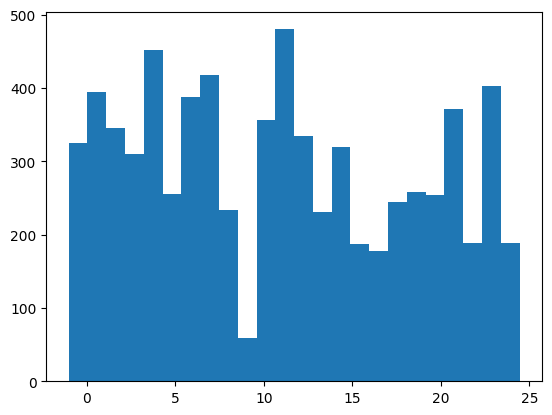

In [52]:
# This is a histogram of counts given to each label
plt.hist(prediction, bins=len(labels))
plt.show()

In [53]:
# Rounds off the labels
prediction_rounded = np.array(prediction)

count = 0
for p in prediction_rounded:
    prediction_rounded[count] = np.round(p)
    count += 1

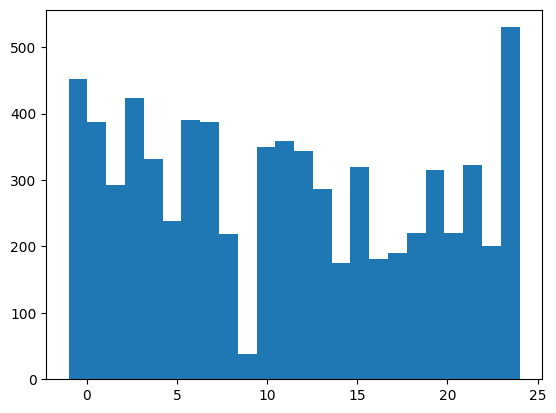

In [54]:
# This is a histogram of counts given to each label
plt.hist(prediction_rounded, bins=len(labels))
plt.show()

In [63]:
total_correct = 0

index = 0
for p in prediction_rounded:
    if p[index] == test_data_labels[index]:
        total_correct += 1

print("Total correct:", total_correct)
print("Total items:", len(test_data_labels))
print("Ratio correct:", total_correct/len(test_data_labels))

Total correct: 390
Total items: 7172
Ratio correct: 0.05437813720022309


Keras stuff - Images

In [56]:
#import tensorflow as tf

#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.models import Sequential

In [57]:
#len(train_data)

In [58]:
#batch_size = 32
#img_height = 28
#img_width = 28

#train_ds = tf.keras.utils.image_dataset_from_directory(
#  data_dir,
#  validation_split=0.2,
#  subset="training",
#  seed=123,
#  image_size=(img_height, img_width),
#  batch_size=batch_size)

In [59]:
#model = Sequential([
#  layers.Rescaling(1./255, input_shape=(28, 28, 3)),
#  layers.Conv2D(16, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(32, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(64, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Flatten(),
#  layers.Dense(128, activation='relu')
#])

In [60]:
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])

In [61]:
#model.summary()

In [62]:
#epochs=10
#history = model.fit(
#  train_data,
#  validation_data=test_data,
#  epochs=epochs
#)